In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz
from sklearn.decomposition import PCA, FastICA
from meegkit import dss
import pandas as pd
from sklearn.cross_decomposition import CCA

In [2]:
folderPath = os.path.join(os.getcwd(), 'SSVEP_BCI_Dataset')

In [3]:
matFiles = [f for f in os.listdir(folderPath) if f.endswith('.mat')]
matData = scipy.io.loadmat(os.path.join(folderPath,matFiles[1]))
# for matFile in matFiles:
#     matData = scipy.io.loadmat(os.path.join(folderPath,matFile))
    # print(os.path.join(folderPath,matFile),'->',matData['data'].shape)

In [4]:
colName = ['Character', 'Frequency(Hz)', 'Phase（pi)']
characters = ['1','2','3','4','5','6','7','8','9','0','*','#']
FreqHz = [9.25,11.25,13.25,9.75,11.75,13.75,10.25,12.25,14.25,10.75,12.75,14.75]
PhasePi = [0,0,0,0.5,0.5,0.5,1,1,1,1.5,1.5,1.5]
simInfo = pd.DataFrame()
simInfo['Character'] = characters
simInfo['Frequency(Hz)'] = FreqHz
simInfo['Phase（pi)'] = PhasePi
simInfo

,Character,Frequency(Hz),Phase（pi)
0,1,9.25,0.0
1,2,11.25,0.0
2,3,13.25,0.0
3,4,9.75,0.5
4,5,11.75,0.5
5,6,13.75,0.5
6,7,10.25,1.0
7,8,12.25,1.0
8,9,14.25,1.0
9,0,10.75,1.5


In [5]:
channelInd = ['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']

In [6]:
sampFreq = 250
timeRange = np.arange(0,2.84,1/sampFreq)
len(timeRange)

710

In [7]:
data = matData['data']
name = ['Time']+channelInd
electrodeIndex = 0
blockIndex = 0
targetIndex = 4
dataMat = [timeRange]
numbChannelIndex = 8
for chnInd in range(numbChannelIndex):
    dataMat.append(data[chnInd,:,electrodeIndex,blockIndex,targetIndex])
df = pd.DataFrame(dataMat)
df = df.transpose()
df.columns = name
df = df.set_index('Time')
df = df * 10**(-6)
df.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,-0.057667,-0.023819,-0.027161,-0.020359,-0.025419,-0.014405,-0.026878,-0.023620
0.004,-0.060079,-0.023675,-0.028126,-0.020050,-0.025200,-0.014110,-0.026707,-0.023370
0.008,-0.060876,-0.023358,-0.027899,-0.019751,-0.024901,-0.013812,-0.026419,-0.023070
0.012,-0.059343,-0.023302,-0.026982,-0.019848,-0.024938,-0.013915,-0.026411,-0.023137
0.016,-0.057336,-0.023600,-0.026529,-0.020232,-0.025269,-0.014291,-0.026705,-0.023494


In [8]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [9]:
# Sample rate and desired cutoff frequencies (in Hz).
# As mentioned An Open Dataset for Wearable SSVEP-Based Brain-Computer Interfaces
lowcut = 7.25
highcut = 90.0

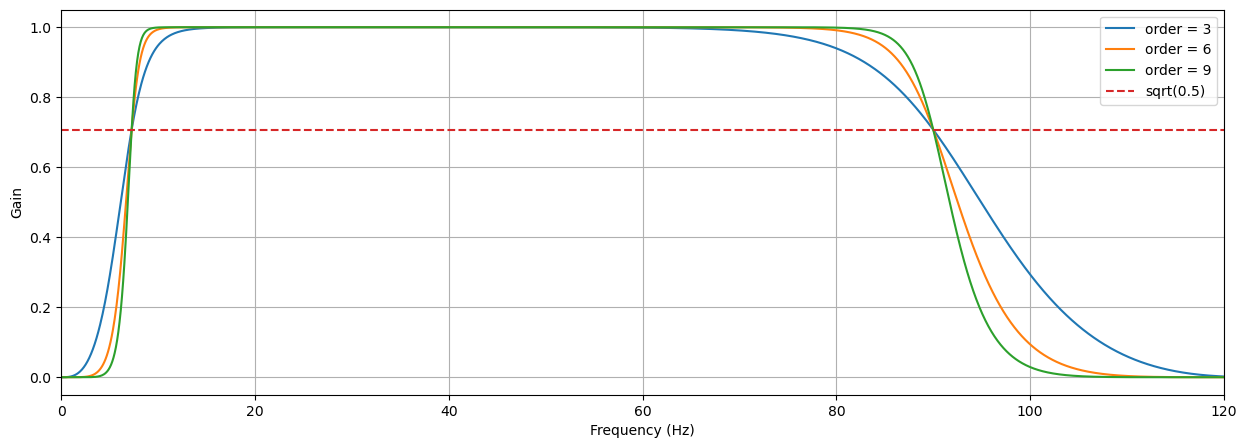

In [10]:
# Plot the frequency response for a few different orders.
plt.figure(figsize=(15,5))
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, sampFreq, order=order)
    w, h = freqz(b, a, fs=sampFreq, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * sampFreq], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.xlim(0,120)
plt.legend(loc='best')

In [11]:
fOz = butter_bandpass_filter(df['Oz'].values, lowcut, highcut, sampFreq, order=6)

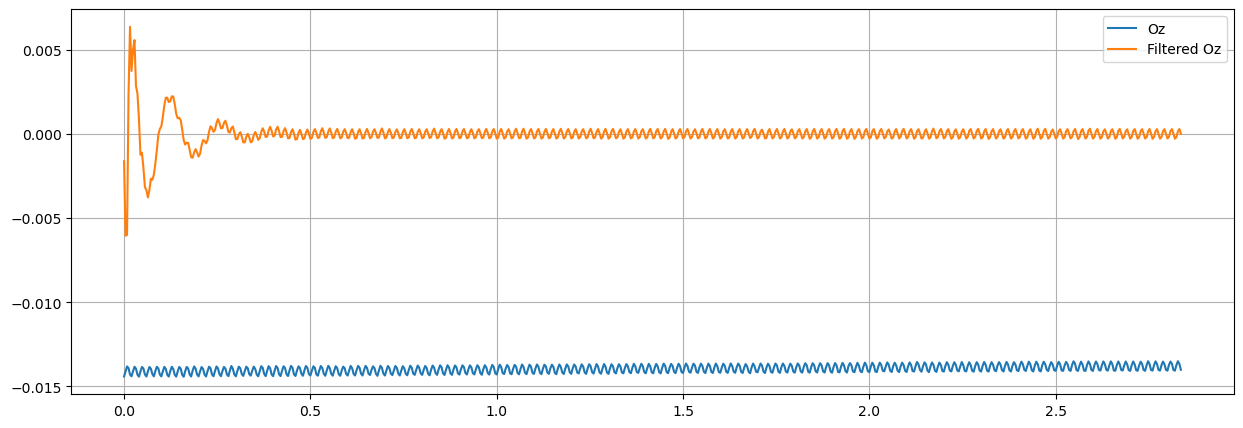

In [12]:
plt.figure(figsize=(15,5))
plt.plot(df.index,df['Oz'].values,label='Oz')
plt.plot(df.index,fOz,label='Filtered Oz')
plt.legend()
plt.grid()
plt.show()

In [13]:
def computeFFT(eeg_data, sampling_rate=250,absVal=True):
    # Length of the signal
    N = len(eeg_data)

    # Compute the FFT
    fft_result = np.fft.fft(eeg_data)

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, 1/sampling_rate)

    # Get the magnitude of the FFT (only the positive half of the spectrum)
    if absVal:
        fft_magnitude = np.abs(fft_result)[:N//2]
    else:
        fft_magnitude = fft_result[:N//2]
    freqs = freqs[:N//2]
    return freqs, fft_magnitude

In [14]:
Freq,Mag = computeFFT(df['Oz'].values)
_,MagFilter = computeFFT(fOz)

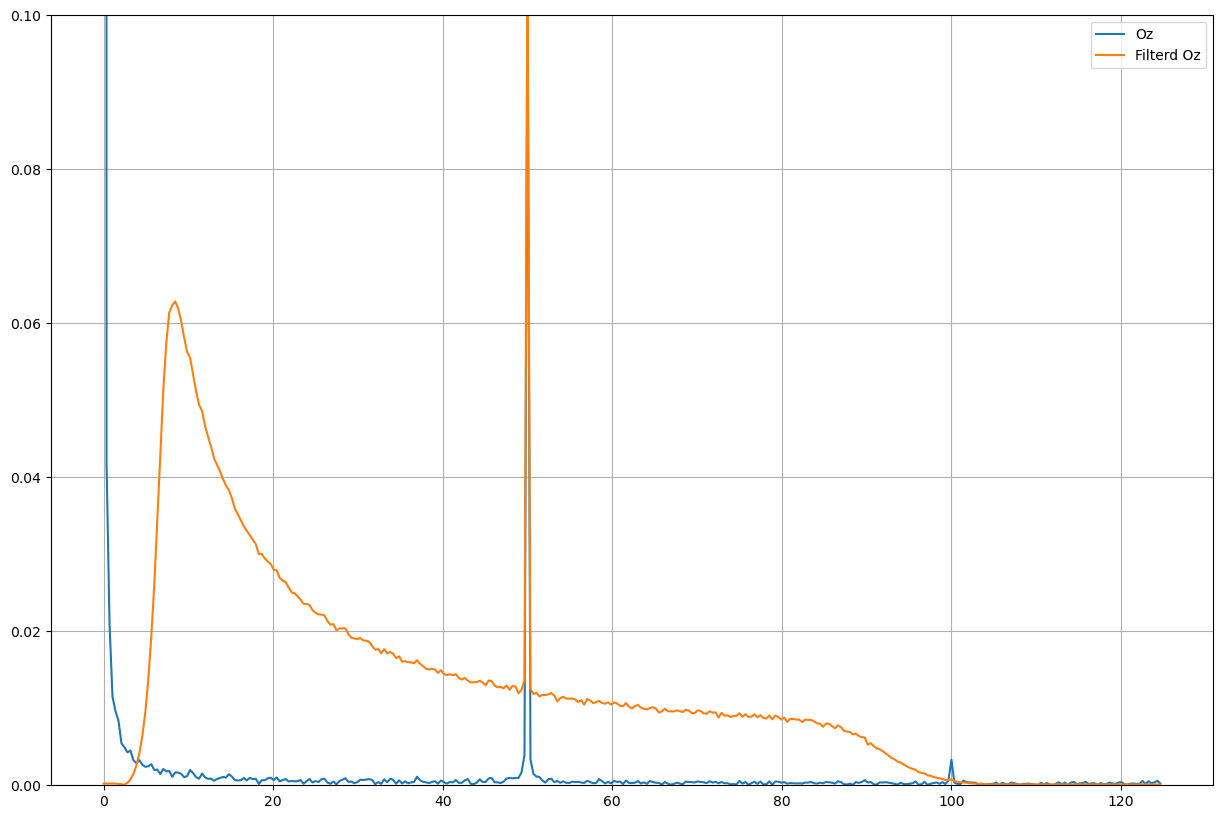

In [15]:
plt.figure(figsize=(15,10))
plt.plot(Freq,Mag,label='Oz')
plt.plot(Freq,MagFilter,label='Filterd Oz')
plt.grid()
# plt.xlim(0,30)
plt.ylim(0,0.1)
plt.legend()
plt.show()

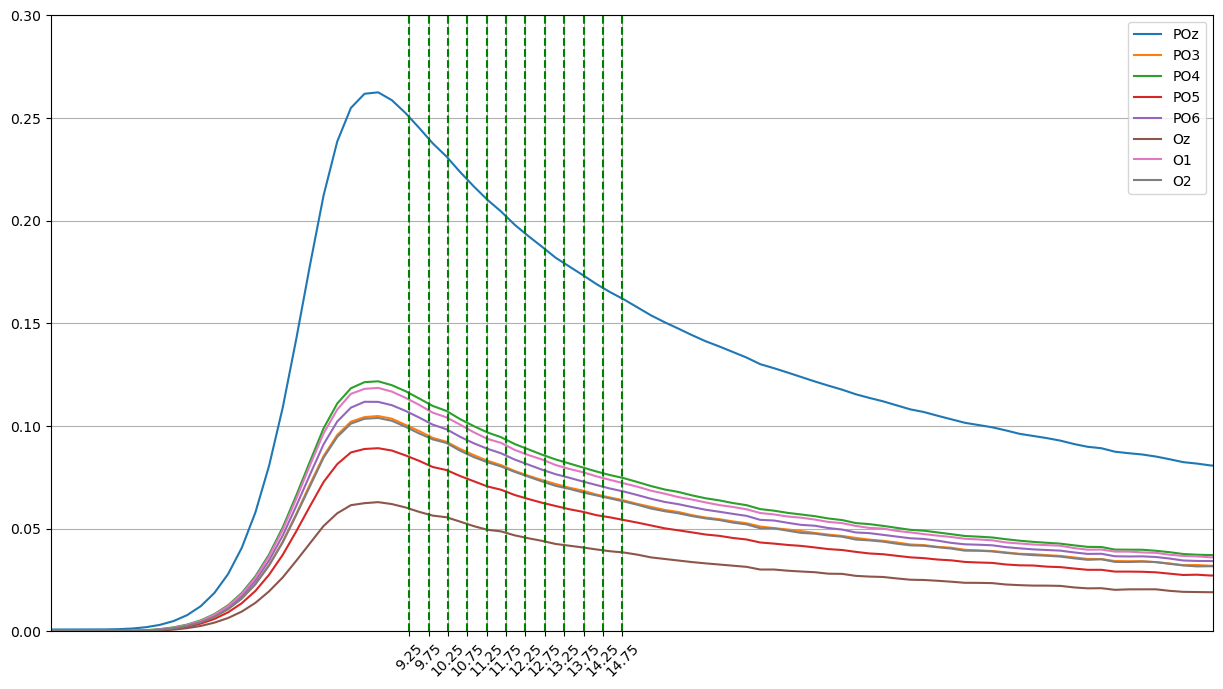

In [16]:
plt.figure(figsize=(15,8))
for ii in channelInd:
    tempSig = butter_bandpass_filter(df[ii].values, lowcut, highcut, sampFreq, order=6)
    Freq,Mag = computeFFT(tempSig)
    plt.plot(Freq,Mag,label=ii)
plt.grid()
plt.xticks(FreqHz+[50, 100],rotation = 45)
plt.xlim(0,30)
plt.vlines(x=FreqHz, ymin=0, ymax= .3, colors='g', ls='--')
plt.ylim(0,0.3)
plt.legend()

plt.show()

## CCA (Canonical Correlation Analysis) 
### with the help of chat gpt

In [18]:
# Sampling frequency
Fs = 250  # Hz

# Time vector (based on the number of EEG samples)
num_samples = len(timeRange)
t = timeRange

In [19]:
# Generate reference signals for each stimulus frequency and phase
def generate_reference_signals(frequency, phase, t, num_harmonics=2):
    """
    Generate reference signals (sine and cosine waves) for a given frequency, phase, and time vector.
    Includes harmonics (default: 2 harmonics).
    """
    reference_signals = []
    
    for harmonic in range(1, num_harmonics+1):
        # Generate sine and cosine waves for the fundamental frequency and harmonics
        ref_sin = np.sin(2 * np.pi * harmonic * frequency * t + phase)
        ref_cos = np.cos(2 * np.pi * harmonic * frequency * t + phase)
        
        # Append to the list of reference signals
        reference_signals.append(ref_sin)
        reference_signals.append(ref_cos)
    
    return np.array(reference_signals)

In [20]:
# Function to apply CCA and find the maximum correlation
def apply_cca(eeg_data, reference_signals):
    """
    Apply Canonical Correlation Analysis (CCA) between EEG data and reference signals.
    Returns the maximum correlation coefficient.
    """
    cca = CCA(n_components=1)  # 1 component for CCA
    cca.fit(eeg_data.T, reference_signals.T)  # Fit CCA on EEG and reference data
    
    # Get the canonical correlation
    eeg_c, ref_c = cca.transform(eeg_data.T, reference_signals.T)
    
    # Compute correlation coefficient (Pearson correlation)
    correlation = np.corrcoef(eeg_c.T, ref_c.T)[0, 1]
    
    return correlation

In [21]:
electrodeIndex = 0
blockIndex = 0
targetIndex = 5

In [22]:
# Apply CCA for each stimulus frequency
max_corr = 0
best_frequency = None
eeg_data = data[:,:,electrodeIndex,blockIndex,targetIndex]* 10**(-6)

In [23]:
for targetIndex in range(12):
    max_corr = 0
    best_frequency = None
    eeg_data = data[:,:,electrodeIndex,blockIndex,targetIndex]* 10**(-6)
    for freq, phase in zip(FreqHz, PhasePi):
        # Convert phase from units of Pi to radians
        phase_rad = phase * np.pi
        
        # Generate reference signals for this frequency and phase
        reference_signals = generate_reference_signals(freq, phase_rad, t, num_harmonics=2)
        
        # Perform CCA and get the correlation
        corr = apply_cca(eeg_data, reference_signals)
        
        # Print or store the results
        # print(f"Frequency: {freq} Hz, Phase: {phase_rad:.2f} rad, Correlation: {corr:.4f}")
        
        # Track the maximum correlation
        if corr > max_corr:
            max_corr = corr
            best_frequency = freq
    
    # Output the detected frequency
    print(f"Detected frequency with highest correlation: {best_frequency} Hz (Correlation: {max_corr:.4f})")
    print(f"Selected frequency for current EEG Data    : {FreqHz[targetIndex]} Hz")
    print(r"-"*75)

Detected frequency with highest correlation: 10.25 Hz (Correlation: 0.1701)
Selected frequency for current EEG Data    : 9.25 Hz
---------------------------------------------------------------------------
Detected frequency with highest correlation: 11.25 Hz (Correlation: 0.2083)
Selected frequency for current EEG Data    : 11.25 Hz
---------------------------------------------------------------------------
Detected frequency with highest correlation: 11.75 Hz (Correlation: 0.1486)
Selected frequency for current EEG Data    : 13.25 Hz
---------------------------------------------------------------------------
Detected frequency with highest correlation: 9.75 Hz (Correlation: 0.1658)
Selected frequency for current EEG Data    : 9.75 Hz
---------------------------------------------------------------------------
Detected frequency with highest correlation: 11.75 Hz (Correlation: 0.1894)
Selected frequency for current EEG Data    : 11.75 Hz
-------------------------------------------------